In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import os
import torch
import json 
from sklearn.preprocessing import StandardScaler

from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation


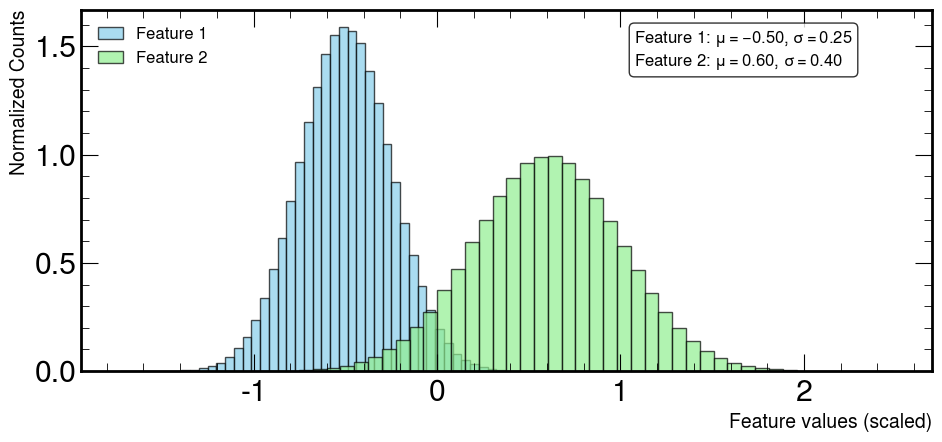

In [2]:
# Use CMS style for plots
hep.style.use("CMS")
# Set job directory manually (change this to the desired job folder)
job_dir = "/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/Normalizing_Flows/EstimationNF_gaussians_outputs/job_4_4_64_8_816167"

# Create 'plots' directory inside the job directory
plots_dir = os.path.join(job_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)

# Load target samples (scaled)
# Load target samples (unscaled) and apply scaling here
target_samples_unscaled = np.load(os.path.join(job_dir, "target_samples.npy"))
scaler = StandardScaler()
target_samples = scaler.fit_transform(target_samples_unscaled)

# Plot 1D histograms for target features
plt.figure(figsize=(10, 5))
plt.hist(target_samples_unscaled[:, 0], bins=50, color='skyblue', density=True, edgecolor='black', alpha=0.7, label='Feature 1')
plt.hist(target_samples_unscaled[:, 1], bins=50, color='lightgreen', density=True, edgecolor='black', alpha=0.7, label='Feature 2')
plt.xlabel("Feature values (scaled)", fontsize=14)
plt.ylabel("Normalized Counts", fontsize=14)
plt.legend(fontsize=12)

# Add text box with means and stds
mean1, std1 = np.mean(target_samples_unscaled[:, 0]), np.std(target_samples_unscaled[:, 0])
mean2, std2 = np.mean(target_samples_unscaled[:, 1]), np.std(target_samples_unscaled[:, 1])
textstr = '\n'.join((
    rf'Feature 1: $\mu = {mean1:.2f}$, $\sigma = {std1:.2f}$',
    rf'Feature 2: $\mu = {mean2:.2f}$, $\sigma = {std2:.2f}$'
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black')
plt.text(0.65, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()    
plt.close()

trained = np.load(os.path.join(job_dir, "trained_samples.npy"))
n_plot = 10000
prior = StandardNormal(shape=(2,)).sample(n_plot).numpy()


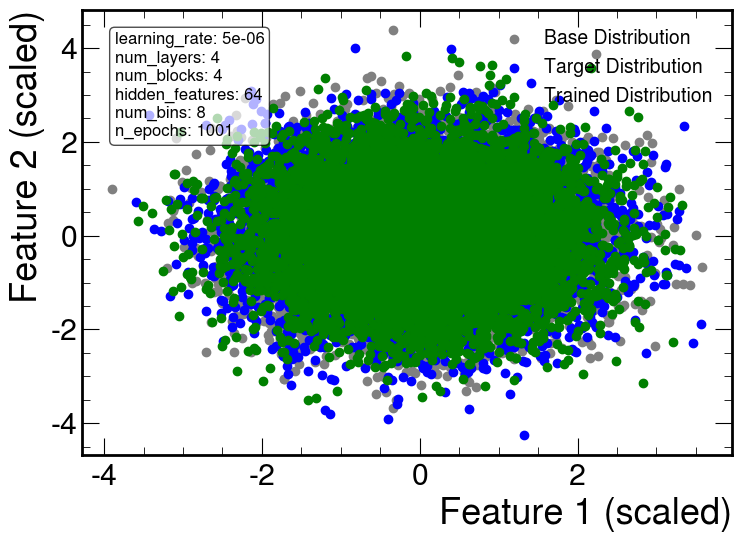

In [4]:
# --------- CONFIGURATION ---------
# Load losses, KL, scaler
train_losses = np.load(os.path.join(job_dir, "train_losses.npy"))
val_losses = np.load(os.path.join(job_dir, "val_losses.npy"))
kl_div = np.load(os.path.join(job_dir, "kl_divergence.npy"))

# Load config
with open(os.path.join(job_dir, "config.json"), "r") as f:
    config = json.load(f)

# Extract variables
num_features = config["num_features"]
num_layers = config["num_layers"]
num_blocks = config["num_blocks"]
hidden_features = config["hidden_features"]
num_bins = config["num_bins"]
learning_rate = config["learning_rate"]
n_epochs = config["n_epochs"]
batch_size = config["batch_size"]

# --- 2D Scatter Plot of Distributions ---
plt.figure(figsize=(8, 6))
plt.scatter(prior[:n_plot, 0], prior[:n_plot, 1], color='gray', label='Base Distribution')
plt.scatter(target_samples[:n_plot, 0], target_samples[:n_plot, 1], color='blue', label='Target Distribution')
plt.scatter(trained[:n_plot, 0], trained[:n_plot, 1], color='green', label='Trained Distribution')
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.legend(loc='upper right', fontsize=14)

# Annotate configuration
config_text = f"""learning_rate: {learning_rate}
num_layers: {num_layers}
num_blocks: {num_blocks}
hidden_features: {hidden_features}
num_bins: {num_bins}
n_epochs: {n_epochs}"""
plt.text(0.05, 0.95, config_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

scatter_path = os.path.join(plots_dir, "scatter.png")
plt.tight_layout()
plt.savefig(scatter_path)
plt.show()    
plt.close()


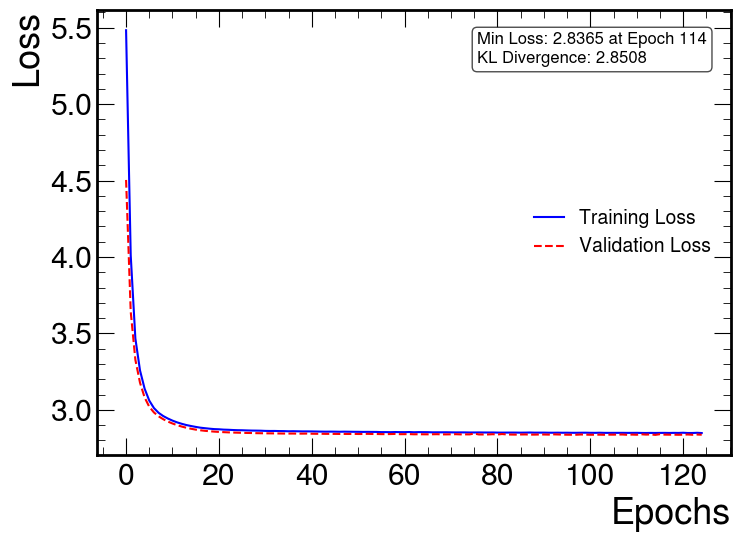

In [5]:
# Plot training and validation loss per epoch
# Training loss: measures how well your model is fitting the target distribution
# Validation loss: measures how well your model generalizes to unseen data fro the same target disribution

# --- Training and Validation Loss Plot ---
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='red', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=14)

# Annotate loss summary
with open(os.path.join(job_dir, "loss_summary.json")) as f:
    summary = json.load(f)
min_loss = summary["min_loss"]
min_loss_epoch = summary["min_loss_epoch"]
loss_text = f"Min Loss: {min_loss:.4f} at Epoch {min_loss_epoch}\nKL Divergence: {kl_div:.4f}"
plt.text(0.6, 0.95, loss_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

loss_path = os.path.join(plots_dir, "loss_curve.png")
plt.tight_layout()
plt.savefig(loss_path)
plt.show()    
plt.close()


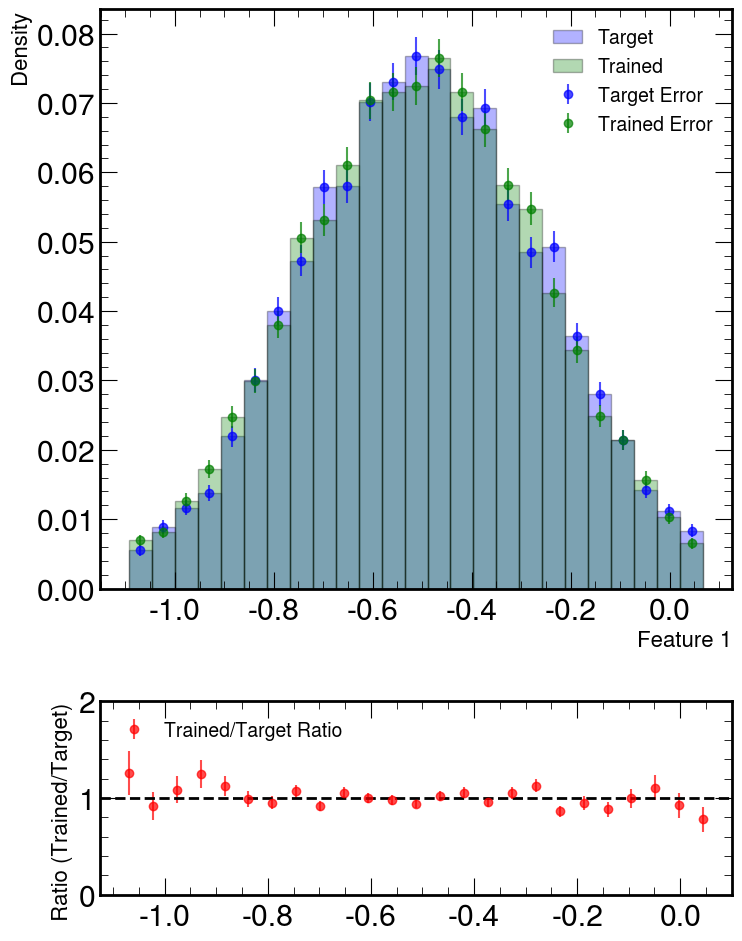

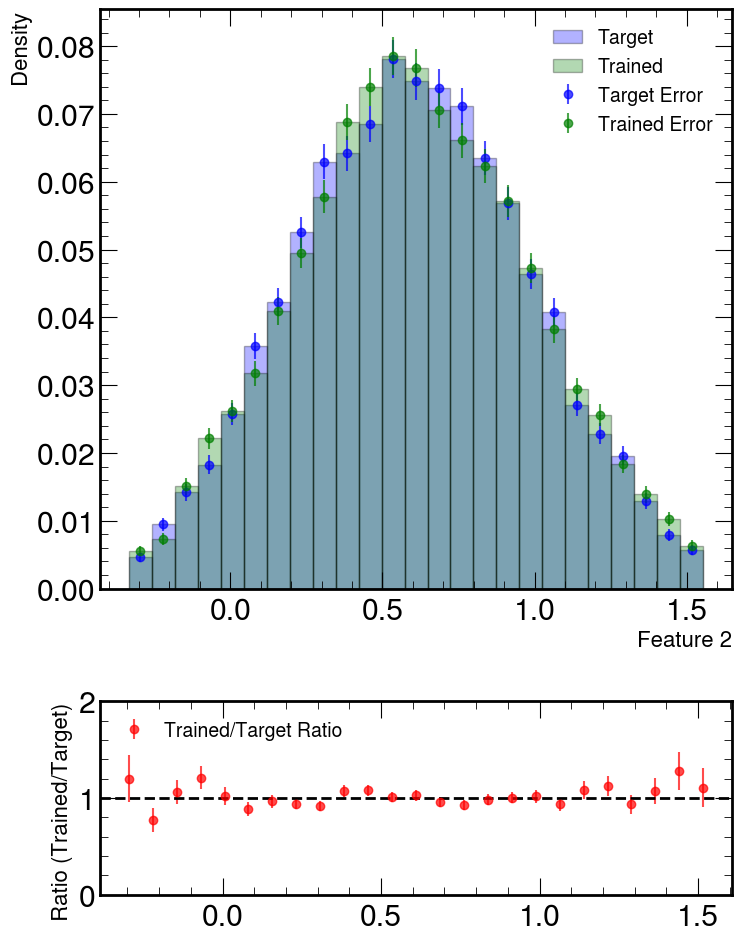

In [7]:
# Function to plot marginal distributions
def plot_marginals(target, trained, feature_names, outdir, scaler):
    num_features = target.shape[1]
    
    # Inverse transform to get original features
    target_original = scaler.inverse_transform(target)
    trained_original = scaler.inverse_transform(trained)
    
    for i in range(num_features):
        fig, (ax_main, ax_ratio) = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [3, 1]})
        
        target_feature = target_original[:, i]
        trained_feature = trained_original[:, i]
        feature_label = feature_names[i]
        
        # Combine data for consistent binning
        bins = 25
        all_data = np.concatenate([target_feature, trained_feature])
        # Use central 98% of data for binning
        low, high = np.percentile(all_data, [1, 99])
        bin_edges = np.linspace(low, high, bins + 1)
            
        # Recalculate the histograms using the same bin edges
        hist_target_counts, _ = np.histogram(target_feature, bins=bin_edges)
        hist_trained_counts, _ = np.histogram(trained_feature, bins=bin_edges)
        
        # Total counts for normalization
        N_target_total = np.sum(hist_target_counts)
        N_trained_total = np.sum(hist_trained_counts)
        
        # Normalize histograms (including empty bins)
        hist_target = hist_target_counts / N_target_total
        hist_trained = hist_trained_counts / N_trained_total
        
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Error estimation for histograms (Poisson)
        err_target = np.sqrt(hist_target_counts) / N_target_total
        err_trained = np.sqrt(hist_trained_counts) / N_trained_total
        
        # Main plot
        ax_main.bar(bin_centers, hist_target, width=np.diff(bin_edges), alpha=0.3, label='Target', color='blue', edgecolor='black')
        ax_main.bar(bin_centers, hist_trained, width=np.diff(bin_edges), alpha=0.3, label='Trained', color='green', edgecolor='black')
        ax_main.errorbar(bin_centers, hist_target, yerr=err_target, fmt='o', color='blue', label='Target Error', alpha=0.7)
        ax_main.errorbar(bin_centers, hist_trained, yerr=err_trained, fmt='o', color='green', label='Trained Error', alpha=0.7)
        ax_main.set_xlabel(feature_label, fontsize=16)
        ax_main.set_ylabel("Density", fontsize=16)
        ax_main.legend(fontsize=14)
        
        # Ratio plot — robust to zero bins
        safe_target = np.where(hist_target > 0, hist_target, np.nan)
        safe_trained = np.where(hist_trained > 0, hist_trained, np.nan)
        ratio = safe_trained / safe_target
        # Mask divisions to avoid division by zero warnings
        with np.errstate(divide='ignore', invalid='ignore'):
            term1 = np.where(hist_target > 0, (err_target / hist_target) ** 2, 0)
            term2 = np.where(hist_trained > 0, (err_trained / hist_trained) ** 2, 0)

        err_ratio = ratio * np.sqrt(term1 + term2)
        
        # Ratio plot (target/trained ratio)
        # Plot only valid (non-NaN) points
        valid = ~np.isnan(ratio)
        ax_ratio.errorbar(bin_centers[valid], ratio[valid], yerr=err_ratio[valid], fmt='o', label='Trained/Target Ratio', color='red', alpha=0.7)
        ax_ratio.set_ylabel("Ratio (Trained/Target)", fontsize=16)
        ax_ratio.legend(fontsize=14, loc='upper left')
        ax_ratio.set_ylim(0.0, 2.0)
        ax_ratio.axhline(y=1, color='black', linestyle='--', linewidth=2)

        # Save plot
        plot_path = os.path.join(outdir, f"marginal_feature_{i+1}.png")
        plt.tight_layout()
        plt.savefig(plot_path)
        plt.show()    
        plt.close()

# Call the function with the necessary arguments
feature_names = ["Feature 1", "Feature 2"]
plot_marginals(target_samples[:n_plot], trained, feature_names, plots_dir, scaler)
